# LinkNet: нейронная сеть для семантической сегментации изображений

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

По архитектуре LinkNet похож на стандартный автоэнкодер: каждый encoder (decoder) блок уменьшает (увеличивает) размерность карт признаков в два раза, в то время как количество карт увеличивается (уменьшается) в два раза. Основное отличие от других нейронных сетей, используемых для сегментации изображений, состоит в соединении encoder и decoder блоков напрямую (skip connections). Такой подход позволяет полнее использовать информацию, содержащуюся в исходном изображении, а также позволяет решить проблему обучения глубоких сетей (данная сеть содержит 32 слоя). Между сверточными слоями используются ReLU.

<img src='./pic/01.PNG' width="400" height="300">

<img src='pic/02.PNG' width="1000" height="400">

Воспользуемся LinkNet для сегментации изображений $128 \times 128$, в которых в случайном месте располагается изображение MNIST $28 \times 28$ и добавлен шум.
<img src='pic/03.PNG' width="200" height="200">

In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm_notebook as tqm
from time import time
import math

import matplotlib.pyplot as plt

sys.path.append(os.path.join('..','..'))

from az_training.dataset import Dataset, DatasetIndex
from az_training.task_02.linknet import LinkNetBatch
from az_training.task_02.plot_functions import plot_example_interactive, plot_examples

%matplotlib inline

In [2]:
MNIST_SIZE = 65000
BATCH_SIZE = 512
MAX_ITER = 100

In [3]:
# создадим индекс и датасет для построения пайплайна

ind = DatasetIndex(np.arange(MNIST_SIZE))
mnistset = Dataset(ind, batch_class=LinkNetBatch)
mnistset.cv_split([0.9, 0.1])

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [5]:
prediction = []
test_loss = []
train_loss = []

In [6]:
# пайплайны для обучения и контроля

ppl = mnistset.train.pipeline()\
        .load_images()\
        .noise_and_mask()\
        .train(sess)\
        .get_stat(sess, train_loss, True)
        
ppl_test = mnistset.test.pipeline()\
            .load_images()\
            .noise_and_mask()\

In [7]:
# обучение

start = time()
for i in range(MAX_ITER):
    ppl.next_batch(BATCH_SIZE, n_epochs=None)
    ppl_test.get_stat(sess, test_loss, False).next_batch(100, n_epochs=None)
    if (i+1) % 10 == 0:
        print("Iter {}: Train loss: {}, test loss: {}".format(i+1, train_loss[-1], test_loss[-1]))
stop = time()
print("Train time: {} min".format((stop-start)/60))

Iter 10: Train loss: 0.4014764726161957, test loss: 0.40555548667907715
Iter 20: Train loss: 0.28155839443206787, test loss: 0.2788664400577545
Iter 30: Train loss: 0.20793579518795013, test loss: 0.20585258305072784
Iter 40: Train loss: 0.15910941362380981, test loss: 0.15874522924423218
Iter 50: Train loss: 0.12489035725593567, test loss: 0.12537257373332977
Iter 60: Train loss: 0.1003534272313118, test loss: 0.10051406174898148
Iter 70: Train loss: 0.08252304792404175, test loss: 0.0824560895562172
Iter 80: Train loss: 0.06901152431964874, test loss: 0.06903742998838425
Iter 90: Train loss: 0.05902836471796036, test loss: 0.05917220190167427
Iter 100: Train loss: 0.05124460905790329, test loss: 0.05134730786085129
Train time: 2.4263363758722942 min


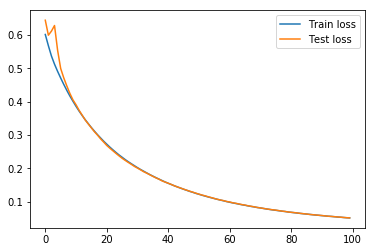

In [8]:
plt1, = plt.plot(train_loss,  label='Train loss')
plt2, = plt.plot(test_loss, label='Test loss')
plt.legend(handles=[plt1, plt2])
plt.show()

In [10]:
with open('with_bn.pkl', 'wb') as file:
    pickle.dump([train_loss, test_loss], file, pickle.HIGHEST_PROTOCOL)

In [15]:
with open('with_bn.pkl', 'rb') as file:
    a, b = pickle.load(file)

In [9]:
prediction = []
images = []
masks = []
ppl_test.get_images(images, masks)\
        .predict_proba(sess, prediction).next_batch(10, n_epochs=None)

In [12]:
with open('predictions128.pkl', 'wb') as output:
    pickle.dump([prediction, images, masks], output, pickle.HIGHEST_PROTOCOL)

In [3]:
with open('predictions128.pkl', 'rb') as inp:
    prediction, images, masks = pickle.load(inp)

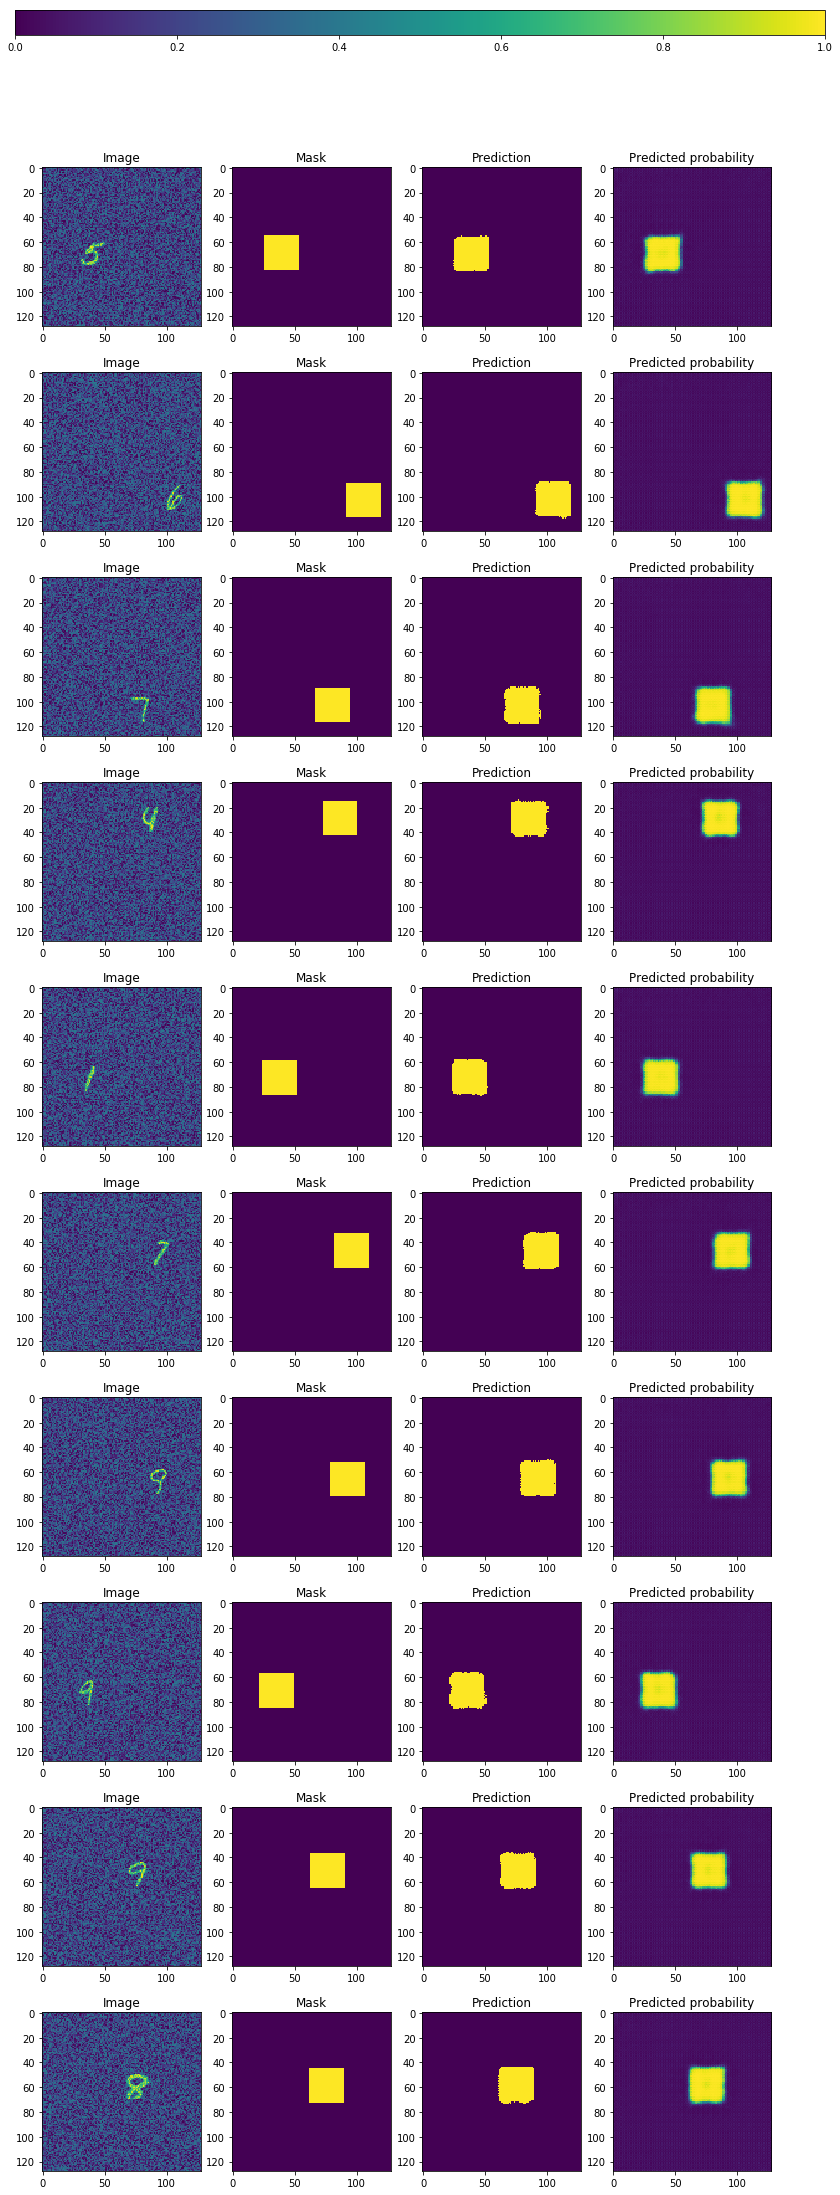

In [10]:
plot_examples(images, masks, prediction)